In [62]:
import copy

import numpy as np
import cv2
import pandas as pd
import os
from os import listdir
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
import skimage
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

PATH = "C:/Users/cubix/Desktop/analiza-obrazow-cyfrowych-projekt/data/DATASET/"
os.listdir(PATH)

['downdog', 'goddess', 'plank', 'tree', 'warrior']

<center><h1> Basic idea with centroid of parts of image</h1></center>

In [63]:
dataset = []
labels = []

for classes in os.listdir(PATH):
    for image in os.listdir(PATH + classes):
        img = cv2.imread(PATH + classes + '/' + image, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resized = cv2.resize(img, (200, 200))
        dataset.append(resized)
        labels.append(classes)

dataset_array = np.asarray(dataset)

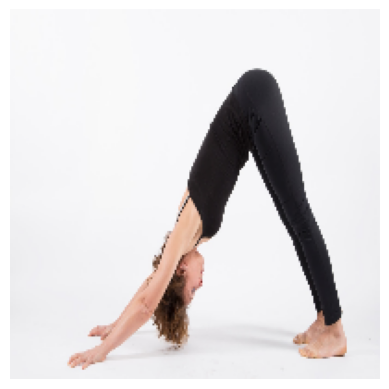

In [64]:
sample_idx = 0
plt.axis('off')
plt.imshow(dataset[sample_idx])
plt.show()

In [65]:
dataset_array = np.asarray(dataset)
canny_list = []

for sample in range(len(dataset_array)):
    gray_img = cv2.cvtColor(dataset_array[sample], cv2.COLOR_RGB2GRAY)
    new_img = skimage.feature.canny(gray_img)
    canny_list.append(new_img)

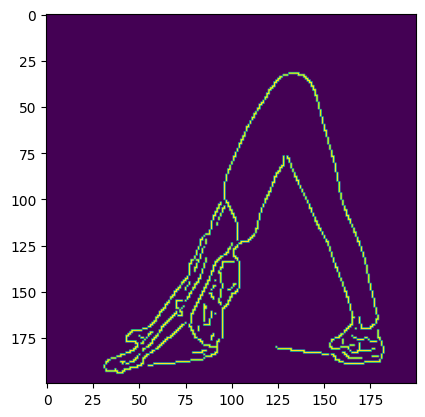

In [66]:
plt.imshow(canny_list[sample_idx])
plt.show()

In [67]:
sample = canny_list[sample_idx]
indices = list(zip(*np.where(sample == 1)))

In [68]:
list(np.mean(indices, axis=0))

[140.5797213622291, 109.36300309597523]

In [69]:
new_img = copy.deepcopy(canny_list[sample_idx])
step = 50
block_points = []

for x_block in range(0, 200, step):
    for y_block in range(0, 200, step):
        indices = list(zip(*np.where(new_img[y_block:y_block+step, x_block:x_block+step] == 1)))
        try:
            if len(indices) > 50:
                mean_indices = list(np.mean(indices, axis=0))
                block_points.append([(y_block, int(mean_indices[0])), (x_block, int(mean_indices[1]))])
        except IndexError:
            continue
block_points

[[(150, 34), (0, 42)],
 [(100, 31), (50, 37)],
 [(150, 19), (50, 24)],
 [(0, 39), (100, 31)],
 [(50, 26), (100, 22)],
 [(100, 20), (100, 14)],
 [(100, 27), (150, 13)],
 [(150, 25), (150, 17)]]

In [70]:
points = [(block_points[idx][1][0] + block_points[idx][1][1], block_points[idx][0][0] + block_points[idx][0][1]) for idx in range(len(block_points))]
points

[(42, 184),
 (87, 131),
 (74, 169),
 (131, 39),
 (122, 76),
 (114, 120),
 (163, 127),
 (167, 175)]

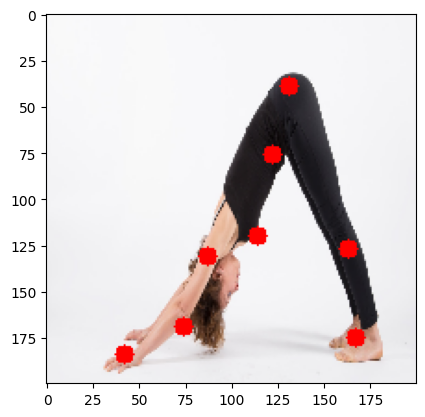

In [71]:
rgb_image = copy.deepcopy(dataset[sample_idx])
for point in points:
    rgb_image = cv2.circle(rgb_image, point, radius=5, color=(255, 0, 0), thickness=-1)
plt.imshow(rgb_image)
plt.show()

In [72]:
mass_x, mass_y = np.where(canny_list[sample_idx] == 1)
cent_x = np.average(mass_x)
cent_y = np.average(mass_y)

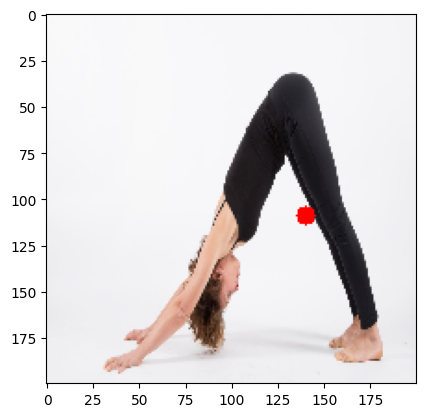

In [73]:
rgb_image = copy.deepcopy(dataset[sample_idx])
# for point in points:
rgb_image = cv2.circle(rgb_image, (int(cent_x), int(cent_y)), radius=5, color=(255, 0, 0), thickness=-1)
plt.imshow(rgb_image)
plt.show()

------------------------------------------------------------------------------------------------------------------------------------------

<center><h1> Experimenting with gaussian blur and grabcut </h1></center>

In [74]:
def show_points(sample: np.array, step: int = 50, treshold: int = 50, already_edges: bool = False):
    rgb_image = copy.deepcopy(sample)

    try:
        sample = cv2.cvtColor(sample, cv2.COLOR_RGB2GRAY)
    except:
        pass

    if already_edges:
        sample = skimage.feature.canny(sample)

    block_points = []

    for x_block in range(0, 200, step):
        for y_block in range(0, 200, step):
            indices = list(zip(*np.where(sample[y_block:y_block + step, x_block:x_block + step] == 1)))
            try:
                if len(indices) > treshold:
                    mean_indices = list(np.mean(indices, axis=0))
                    block_points.append([(y_block, int(mean_indices[0])), (x_block, int(mean_indices[1]))])
            except IndexError:
                continue

    points = [(block_points[idx][1][0] + block_points[idx][1][1], block_points[idx][0][0] + block_points[idx][0][1]) for idx in range(len(block_points))]

    for point in points:
        rgb_image = cv2.circle(rgb_image, point, radius=5, color=(255, 0, 0), thickness=-1)

    plt.imshow(rgb_image)
    plt.show()

In [75]:
def canny(sample: np.array):
    try:
        sample = cv2.cvtColor(sample, cv2.COLOR_RGB2GRAY)
    except:
        pass
    return skimage.feature.canny(sample)

def gaussian(sample: np.array, kernel_size: int = 5,):
    gaussian_kernel = np.ones((kernel_size, kernel_size), np.float32) / 25
    return cv2.filter2D(sample, -1, gaussian_kernel)

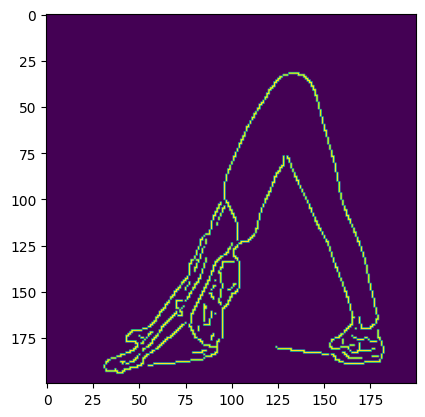

In [76]:
plt.imshow(canny_list[sample_idx])
plt.show()

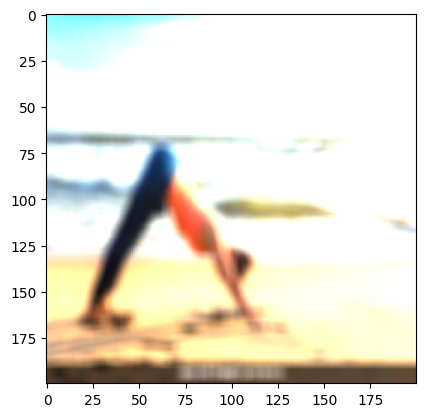

In [77]:
sample_idx = 290
# filtered_img = skimage.filters.gaussian(dataset[sample_idx], sigma=3, channel_axis=-1)

kernel = np.ones((7,7), np.float32) / 25
dst = cv2.filter2D(dataset[sample_idx], -1, kernel)
plt.imshow(dst)
plt.show()

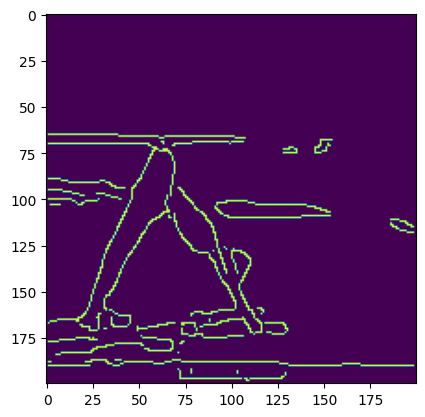

In [78]:
filtered_img = cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY)
plt.imshow(skimage.feature.canny(filtered_img))
plt.show()

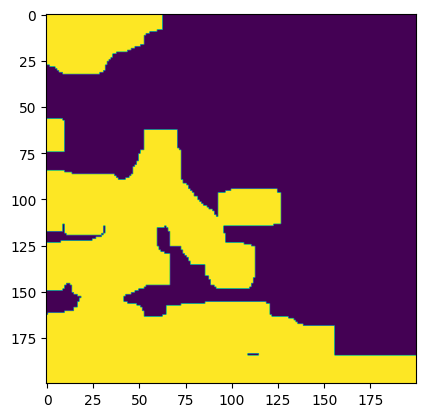

In [79]:
# grabcut needs tuning but may be useful for character extraction
PATH = '../../data/DATASET/downdog/00000376.jpg'
gaussian_kernel = np.ones((5,5), np.float32) / 25

gray_sample = cv2.imread(PATH, cv2.IMREAD_GRAYSCALE)
gray_sample = cv2.resize(gray_sample, (200, 200))
gray_sample = cv2.filter2D(gray_sample, -1, gaussian_kernel)

kernel = np.ones((5,5), np.uint8)
closing = cv2.morphologyEx(gray_sample, cv2.MORPH_CLOSE, kernel, iterations=3)
erosion = cv2.morphologyEx(closing, cv2.MORPH_ERODE, kernel, iterations=1)

mask = np.zeros(sample.shape[:2], np.uint8)
mask[:] = 2
mask[erosion >= 150]= 1
bgdmodel = np.zeros((1, 65), np.float64)
fgdmodel = np.zeros((1, 65), np.float64)

sample = cv2.imread(PATH, cv2.IMREAD_COLOR)
sample = cv2.resize(sample, (200, 200))
sample = cv2.filter2D(sample, -1, gaussian_kernel)

out_mask = mask.copy()
out_mask, _, _ = cv2.grabCut(sample, out_mask, None, bgdmodel, fgdmodel, 1, cv2.GC_INIT_WITH_MASK)
out_mask = np.where((out_mask==2)|(out_mask==0),0,1).astype('uint8')
out_img = sample * out_mask[:,:,np.newaxis]
plt.imshow(mask)
plt.show()

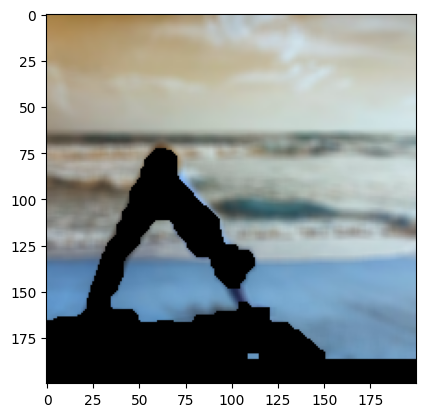

In [80]:
plt.imshow(out_img)
plt.show()

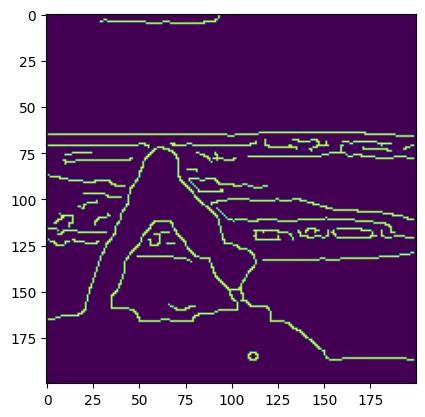

In [81]:
out_img = cv2.cvtColor(out_img, cv2.COLOR_RGB2GRAY)
plt.imshow(skimage.feature.canny(out_img))
plt.show()

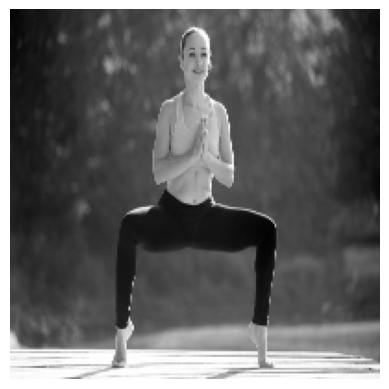

In [82]:
gaussian_kernel = np.ones((5,5), np.float32) / 25

# for idx in range(20):
out_img = cv2.cvtColor(dataset[504], cv2.COLOR_BGR2GRAY)
# out_img = cv2.filter2D(out_img, -1, gaussian_kernel)
# out_img = skimage.feature.canny(out_img)

plt.axis('off')
plt.imshow(out_img, cmap='gray')
plt.show()

--------------------------------------------------------------------------------------------------------------------------------

<center><h1> Building forest model </h1></center>

In [154]:
def produce_dots(sample: np.array, step: int = 50, treshold: int = 50, kernel_size: int = 5, kernel_strength: int = 25, cut_out: bool = False):
    too_many_dots = False
    pointed_output = np.zeros_like(sample)
    kernel = np.ones((kernel_size, kernel_size), np.float32) / kernel_strength
    sample = cv2.filter2D(sample, -1, kernel)

    try:
        sample = cv2.cvtColor(sample, cv2.COLOR_RGB2GRAY)
    except:
        pass

    sample = skimage.feature.canny(sample)

    block_points = []

    for x_block in range(0, 200, step):
        for y_block in range(0, 200, step):
            indices = list(zip(*np.where(sample[y_block:y_block + step, x_block:x_block + step] == 1)))
            try:
                if len(indices) > treshold:
                    mean_indices = list(np.mean(indices, axis=0))
                    block_points.append([(y_block, int(mean_indices[0])), (x_block, int(mean_indices[1]))])
            except IndexError:
                continue

    points = [(block_points[idx][1][0] + block_points[idx][1][1], block_points[idx][0][0] + block_points[idx][0][1]) for idx in range(len(block_points))]

    if cut_out:
        if len(points) > 10 or len(points) < 4:
            too_many_dots = True
            return pointed_output, len(points), too_many_dots

    for point in points:
        pointed_output = cv2.circle(pointed_output, point, radius=5, color=(255, 0, 0), thickness=-1)

    pointed_output = cv2.cvtColor(pointed_output, cv2.COLOR_RGB2GRAY)
    return pointed_output, len(points), too_many_dots

In [155]:
pointed_images = []
length_of_points = []
flags = []
for image in dataset:
    pointed_output, length_of_point, flag = produce_dots(image, step=50, treshold=50, kernel_size=6, kernel_strength=25, cut_out=True)
    pointed_images.append(pointed_output)
    length_of_points.append(length_of_point)
    flags.append(flag)

In [156]:
def cut_out_samples(pointed_images: list, labels: list, flags: list):
    new_pointed_images = []
    new_labels = []

    for idx in range(len(flags)):
        if not flags[idx]:
            new_pointed_images.append(pointed_images[idx])
            new_labels.append(labels[idx])

    return new_pointed_images, new_labels

In [157]:
pointed_images, new_labels = cut_out_samples(pointed_images, labels, flags)

In [158]:
# from collections import Counter
# plt.hist(length_of_points, bins=len(Counter(length_of_points)))

In [159]:
dataset_array = np.asarray(pointed_images)
labels_array = np.asarray(new_labels)
labels_encoded = OneHotEncoder().fit_transform(np.reshape(labels_array, newshape=(len(labels_array), 1))).toarray()

In [160]:
dataset_array_reshaped = dataset_array.reshape((dataset_array.shape[0], dataset_array.shape[1] * dataset_array.shape[2]))

0.03327488899230957


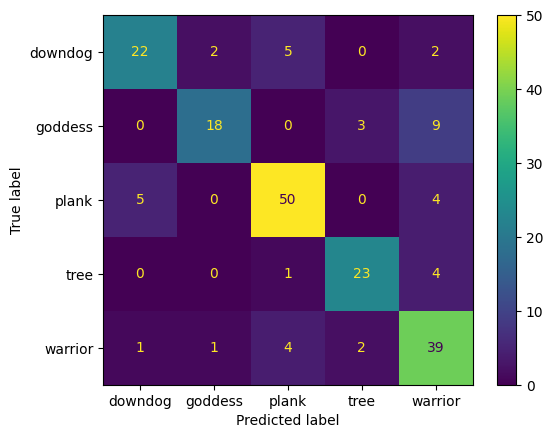

In [161]:
import time
PATH = "C:/Users/cubix/Desktop/analiza-obrazow-cyfrowych-projekt/data/DATASET/"

X_train, X_test, y_train, y_test = train_test_split(dataset_array_reshaped, labels_array, test_size=0.2)
tree = RandomForestClassifier().fit(X_train, y_train)

start_time = time.time()
y_pred = tree.predict(X_test)
print(time.time() - start_time)

cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(cm, display_labels=os.listdir(PATH))
display.plot()
plt.show()

In [152]:
print(balanced_accuracy_score(y_test, y_pred))

0.7865706847849705


21.63787865638733


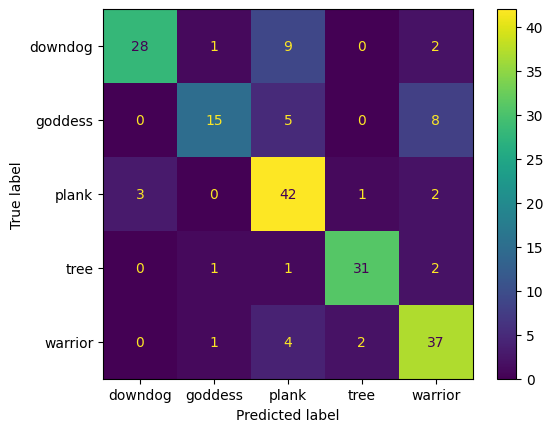

In [166]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(dataset_array_reshaped, labels_array, test_size=0.2)
tree = SVC().fit(X_train, y_train)

start_time = time.time()
y_pred = tree.predict(X_test)
print(time.time() - start_time)

cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(cm, display_labels=os.listdir(PATH))
display.plot()
plt.show()

In [167]:
print(balanced_accuracy_score(y_test, y_pred))

0.7674675324675324


In [113]:
dataset = []
labels = []

for classes in os.listdir(PATH):
    for image in os.listdir(PATH + classes):
        img = cv2.imread(PATH + classes + '/' + image, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resized = cv2.resize(img, (200, 200))
        dataset.append(resized)
        labels.append(classes)

In [114]:
step = [25, 50, 60, 75]
treshold = [50, 60, 70]
kernel_size = [5, 6, 7]

scores = dict()

for stp in step:
    for trsh in treshold:
        for ks in kernel_size:

            pointed_images = []
            flags = []
            for image in dataset:
                pointed_output, _, flag = produce_dots(image, step=stp, treshold=trsh, kernel_size=ks, kernel_strength=25, cut_out=True)
                pointed_images.append(pointed_output)
                flags.append(flag)

            pointed_images, new_labels = cut_out_samples(pointed_images, labels, flags)

            dataset_array = np.asarray(pointed_images)
            labels_array = np.asarray(new_labels)
            labels_encoded = OneHotEncoder().fit_transform(np.reshape(labels_array, newshape=(len(labels_array), 1))).toarray()

            dataset_array = dataset_array.reshape((dataset_array.shape[0], dataset_array.shape[1] * dataset_array.shape[2]))

            X_train, X_test, y_train, y_test = train_test_split(dataset_array, labels_array, test_size=0.2)
            tree = RandomForestClassifier().fit(X_train, y_train)
            y_pred = tree.predict(X_test)
            scores[(stp, trsh, ks)] = balanced_accuracy_score(y_test, y_pred)
            print('Done')

KeyboardInterrupt: 

In [ ]:
max(scores.values())

In [ ]:
scores

In [ ]:
step = [25, 50, 60]
treshold = [50, 60]
kernel_size = [3, 4, 5]
cut_outs = [True, False]

scores = dict()

for stp in step:
    for trsh in treshold:
        for ks in kernel_size:
            for cut_out in cut_outs:
                pointed_images = []
                flags = []
                for image in dataset:
                    pointed_output, _, flag = produce_dots(image, step=stp, treshold=trsh, kernel_size=ks, kernel_strength=25, cut_out=cut_out)
                    pointed_images.append(pointed_output)
                    flags.append(flag)

                pointed_images, new_labels = cut_out_samples(pointed_images, labels, flags)

                dataset_array = np.asarray(pointed_images)
                labels_array = np.asarray(new_labels)
                labels_encoded = OneHotEncoder().fit_transform(np.reshape(labels_array, newshape=(len(labels_array), 1))).toarray()

                dataset_array = dataset_array.reshape((dataset_array.shape[0], dataset_array.shape[1] * dataset_array.shape[2]))

                X_train, X_test, y_train, y_test = train_test_split(dataset_array, labels_array, test_size=0.2)
                tree = RandomForestClassifier().fit(X_train, y_train)
                y_pred = tree.predict(X_test)
                scores[(stp, trsh, ks, cut_out)] = balanced_accuracy_score(y_test, y_pred)
                print('Done')

In [ ]:
max(scores.values())

In [ ]:
scores

<center><h1> Random walker </h1></center>

In [115]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.segmentation import random_walker
from skimage.data import binary_blobs
from skimage.exposure import rescale_intensity
import skimage

from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt
import argparse

rng = np.random.default_rng()

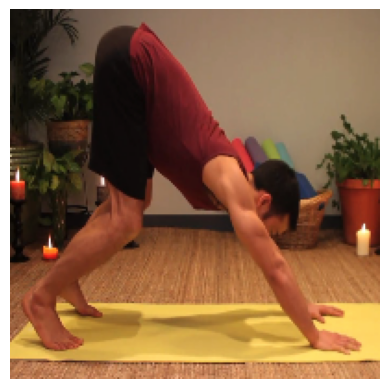

In [116]:
sample_idx = 192
plt.axis('off')
plt.imshow(dataset[sample_idx])
plt.show()

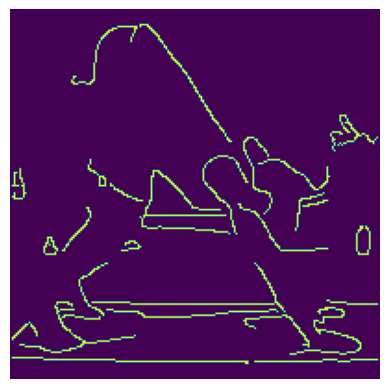

In [117]:
gaussed = gaussian(dataset[sample_idx], kernel_size=3)
cannied = canny(gaussed)

plt.axis('off')
plt.imshow(cannied)
plt.show()

In [118]:
# Generate noisy synthetic data
# data = skimage.img_as_float(binary_blobs(length=128, seed=1))
data = cv2.cvtColor(gaussed, cv2.COLOR_RGB2GRAY)
# plt.imshow(data)
sigma = 10
data = np.add(rng.normal(loc=0, scale=sigma, size=data.shape), data, casting='unsafe')
data = rescale_intensity(data, in_range=(-sigma, 1 + sigma),
                         out_range=(-1, 1))

# The range of the binary image spans over (-1, 1).
# We choose the hottest and the coldest pixels as markers.
markers = np.zeros(data.shape, dtype=np.uint)
markers[data < -0.95] = 1
markers[data > 0.95] = 2

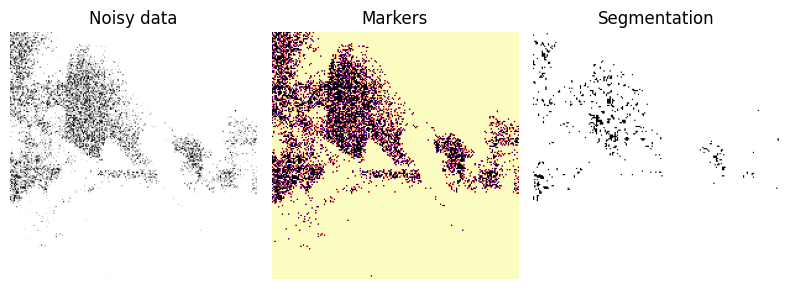

In [119]:
segmented_img = random_walker(data, markers, beta=10, mode='bf')

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3.2),
                                    sharex=True, sharey=True)
ax1.imshow(data, cmap='gray')
ax1.axis('off')
ax1.set_title('Noisy data')
ax2.imshow(markers, cmap='magma')
ax2.axis('off')
ax2.set_title('Markers')
ax3.imshow(segmented_img, cmap='gray')
ax3.axis('off')
ax3.set_title('Segmentation')

fig.tight_layout()
plt.show()

In [120]:
sample = segmented_img
treshold = 25
step = 25


pointed_output = np.zeros_like(dataset[sample_idx])
# kernel = np.ones((kernel_size, kernel_size), np.float32) / 25
# sample = cv2.filter2D(sample, -1, kernel)

block_points = []

for x_block in range(0, 200, step):
    for y_block in range(0, 200, step):
        indices = list(zip(*np.where(sample[y_block:y_block + step, x_block:x_block + step] == 1)))
        try:
            if len(indices) > treshold:
                mean_indices = list(np.mean(indices, axis=0))
                block_points.append([(y_block, int(mean_indices[0])), (x_block, int(mean_indices[1]))])
        except IndexError:
            continue

points = [(block_points[idx][1][0] + block_points[idx][1][1], block_points[idx][0][0] + block_points[idx][0][1]) for idx in range(len(block_points))]

for point in points:
    pointed_output = cv2.circle(pointed_output, point, radius=5, color=(255, 0, 0), thickness=-1)

pointed_output = cv2.cvtColor(pointed_output, cv2.COLOR_RGB2GRAY)


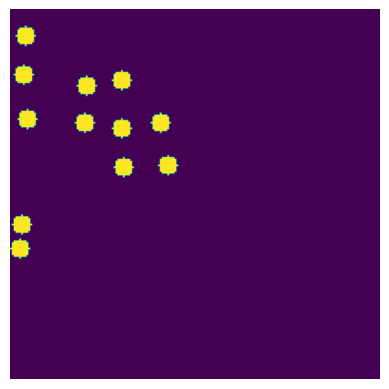

In [121]:
plt.axis('off')
plt.imshow(pointed_output)
plt.show()

In [122]:
# image = dataset[sample_idx]
# # loop over the number of segments
# for numSegments in (5, 7, 12):
# 	# apply SLIC and extract (approximately) the supplied number
# 	# of segments
# 	segments = slic(image, n_segments = numSegments, sigma = 1, enforce_connectivity=True)
# 	# show the output of SLIC
# 	fig = plt.figure("Superpixels -- %d segments" % (numSegments))
# 	ax = fig.add_subplot(1, 1, 1)
# 	ax.imshow(mark_boundaries(image, segments))
# 	plt.axis("off")
# # show the plots
# plt.show()

In [123]:
# segments = slic(image, n_segments = 7, sigma = 3, enforce_connectivity=False)
# boundaries = mark_boundaries(np.zeros_like(image), segments)
# plt.imshow(boundaries)

In [124]:
# sample = boundaries
# treshold = 50
# step = 50
#
#
# pointed_output = np.zeros_like(dataset[sample_idx])
# # kernel = np.ones((kernel_size, kernel_size), np.float32) / 25
# # sample = cv2.filter2D(sample, -1, kernel)
#
# block_points = []
#
# for x_block in range(0, 200, step):
#     for y_block in range(0, 200, step):
#         indices = list(zip(*np.where(sample[y_block:y_block + step, x_block:x_block + step] == 1)))
#         try:
#             if len(indices) > treshold:
#                 mean_indices = list(np.mean(indices, axis=0))
#                 block_points.append([(y_block, int(mean_indices[0])), (x_block, int(mean_indices[1]))])
#         except IndexError:
#             continue
#
# points = [(block_points[idx][1][0] + block_points[idx][1][1], block_points[idx][0][0] + block_points[idx][0][1]) for idx in range(len(block_points))]
#
# for point in points:
#     pointed_output = cv2.circle(pointed_output, point, radius=5, color=(255, 0, 0), thickness=-1)
#
# pointed_output = cv2.cvtColor(pointed_output, cv2.COLOR_RGB2GRAY)


In [125]:
# plt.axis('off')
# plt.imshow(pointed_output)
# plt.show()